<a href="https://colab.research.google.com/github/slisovych/machine_learning_hometasks/blob/main/HW_NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [3]:
import pandas as pd
raw_df = pd.read_csv('train.csv')
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
raw_df.isna().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [6]:
raw_df.dropna(inplace=True)

print(f"стало після видалення: {len(raw_df)}")

стало після видалення: 27480


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [7]:
raw_df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [8]:
raw_df['sentiment']. value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


<Axes: xlabel='sentiment'>

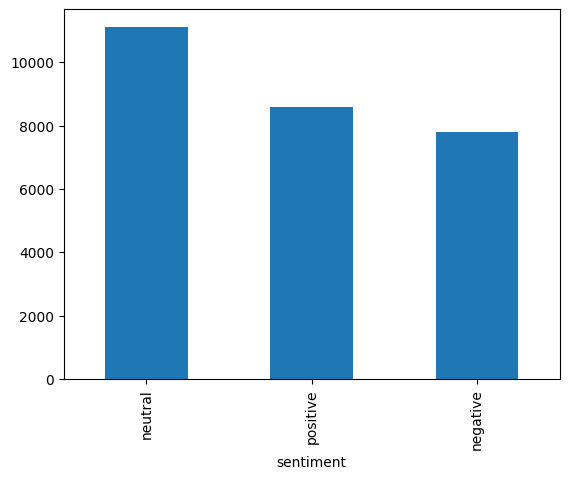

In [9]:
raw_df['sentiment']. value_counts().plot(kind='bar')

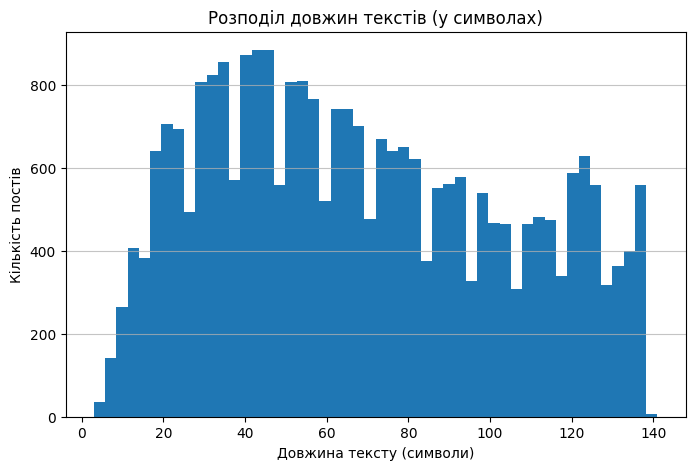

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

raw_df["text_length"] = raw_df["text"].apply(len)

# Побудова гістограми розподілу
plt.figure(figsize=(8, 5))
plt.hist(raw_df["text_length"], bins=50)
plt.title("Розподіл довжин текстів (у символах)")
plt.xlabel("Довжина тексту (символи)")
plt.ylabel("Кількість постів")
plt.grid(axis='y', alpha=0.75)
plt.show()


In [11]:
most_common_length = raw_df["text_length"].mode()[0]
mean_length = raw_df["text_length"].mean()
median_length = raw_df["text_length"].median()

most_common_length, mean_length, median_length

(np.int64(41), np.float64(68.33002183406114), 64.0)

 ## **Спостереження**

більшість постів мають довжину 41 символ;

середня довжина посту - 68 символів;

медіанна довжина 64 символи;

пік розподілу у діапазаоні 30-50 символів (коротші повідомлення переважають);

розподіл правоскошений, є менш часті, але довші пости.


### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [12]:

import re
import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import numpy as np


In [13]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [15]:
raw_df['text'] = raw_df['text'].apply(lambda x:clean_text(x))
raw_df.head()

,textID,text,selected_text,sentiment,text_length
0,cb774db0d1,id have responded if i were going,"I`d have responded, if I were going",neutral,36
1,549e992a42,sooo sad i will miss you here in san diego,Sooo SAD,negative,46
2,088c60f138,my boss is bullying me,bullying me,negative,25
3,9642c003ef,what interview leave me alone,leave me alone,negative,31
4,358bd9e861,sons of why couldnt they put them on the rel...,"Sons of ****,",negative,75


In [16]:
texts = raw_df['text'].astype(str)

# Ініціалізація інструментів
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Функція токенізації з видаленням стоп-слів та стемінгом
def tokenize(text):
    tokens = word_tokenize(text)           # токенізація
    tokens = [t for t in tokens if t not in stop_words]  # видалення стоп-слів
    stems = [stemmer.stem(t) for t in tokens]         # стемінг
    return stems

Оптимальна кількість слів для покриття 95% вживань: 11577


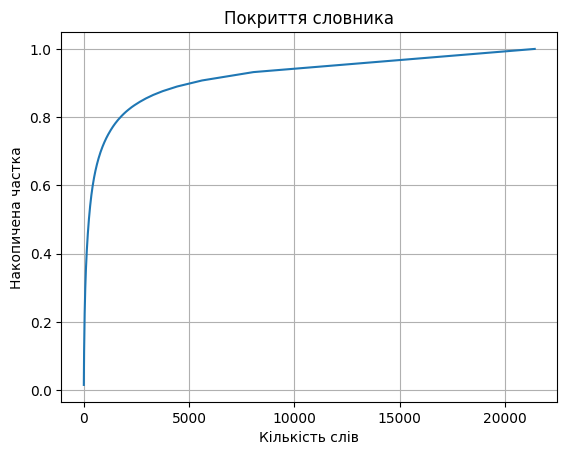

In [17]:
# Додатковий аналіз для вибору max_features
all_tokens = []
for txt in raw_df['text']:
    all_tokens.extend(tokenize(txt))

token_counts = Counter(all_tokens)
total_tokens = sum(token_counts.values())

# накопичена частка
cum_sum = np.cumsum([count for _, count in token_counts.most_common()])
cum_percent = cum_sum / total_tokens

# визначаємо кількість слів для покриття 95% частоти
optimal_features_95 = np.argmax(cum_percent >= 0.95) + 1
print(f"Оптимальна кількість слів для покриття 95% вживань: {optimal_features_95}")

# графік
plt.plot(cum_percent)
plt.xlabel("Кількість слів")
plt.ylabel("Накопичена частка")
plt.title("Покриття словника")
plt.grid(True)
plt.show()


In [18]:
# BOW
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=stop_words,
                             max_features=10000)

X_bow = vectorizer.fit_transform(raw_df['text'])
print("Розмірність матриці:", X_bow.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


Розмірність матриці: (27480, 10000)


In [19]:
vectorizer.get_feature_names_out()[:100]

array(['aaaa', 'aaaaaoouoouoouu', 'aaaagggessss', 'aaaagh', 'aaaah',
       'aaaahh', 'aaaaiieee', 'aaaargh', 'aaaau', 'aaaaw', 'aaaawww',
       'aaah', 'aaahaha', 'aaahh', 'aaahhh', 'aaaw', 'aaawww', 'aah',
       'aargh', 'aaron', 'ab', 'abandon', 'abbey', 'abbi', 'abbrevi',
       'abc', 'abi', 'abid', 'abil', 'abit', 'abl', 'aboard', 'abram',
       'abroad', 'absent', 'absolut', 'absolutley', 'abt', 'abus',
       'abuzz', 'ac', 'academ', 'academi', 'accadent', 'accent', 'accept',
       'access', 'accid', 'accident', 'accompani', 'accomplish', 'accord',
       'account', 'acct', 'accus', 'ace', 'ach', 'achi', 'achiev', 'acid',
       'ack', 'acoust', 'acquir', 'across', 'act', 'action', 'activ',
       'actor', 'actress', 'actual', 'ad', 'ada', 'adam', 'adapt', 'add',
       'addict', 'addin', 'addit', 'addon', 'address', 'adel', 'adem',
       'adium', 'adjust', 'admir', 'admit', 'adob', 'adopt', 'ador',
       'adriana', 'adsens', 'adult', 'advanc', 'advantag', 'adventur',
   

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [21]:

# Кодування цільової змінної
le = LabelEncoder()
y = le.fit_transform(raw_df['sentiment'])

In [22]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    raw_df['text'], y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=stop_words,
                             max_features=10000)

X_train_bow = vectorizer.fit_transform(X_train_bow)
X_test_bow = vectorizer.transform(X_test_bow)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [24]:
X_train_bow.shape, X_test_bow.shape, y_train.shape, y_test.shape

((21984, 10000), (5496, 10000), (21984,), (5496,))

## LogisticRegression

In [25]:
lr = LogisticRegression(solver = 'sag', max_iter=1000)
lr.fit(X_train_bow, y_train)

LogisticRegression(max_iter=1000, solver='sag')

In [26]:
train_bow_preds = lr.predict(X_train_bow)

In [27]:
pd.Series(train_bow_preds).value_counts(normalize=True)

,proportion
1,0.439456
2,0.300946
0,0.259598


In [28]:
pd.Series(y_train).value_counts(normalize=True)

,proportion
1,0.404567
2,0.312273
0,0.283160


In [29]:
# Передбачення на train і test
y_train_pred = lr.predict(X_train_bow)
y_test_pred = lr.predict(X_test_bow)

# Метрики
print(f"Train: Accuracy={accuracy_score(y_train, y_train_pred):.4f}, "
      f"F1={f1_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"Test:  Accuracy={accuracy_score(y_test, y_test_pred):.4f}, "
      f"F1={f1_score(y_test, y_test_pred, average='weighted'):.4f}")

Train: Accuracy=0.8491, F1=0.8491
Test:  Accuracy=0.6874, F1=0.6879


## LightGBM, XGBoost

In [30]:
import lightgbm as lgb
from xgboost import XGBClassifier

In [31]:
# LightGBM модель
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.5,
    max_depth=7,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train_bow.astype('float32'), y_train)

y_train_pred_lgb = lgb_model.predict(X_train_bow.astype('float32'))
y_test_pred_lgb = lgb_model.predict(X_test_bow.astype('float32'))

lgb_train_acc = accuracy_score(y_train, y_train_pred_lgb)
lgb_train_f1 = f1_score(y_train, y_train_pred_lgb, average='weighted')
lgb_test_acc = accuracy_score(y_test, y_test_pred_lgb)
lgb_test_f1 = f1_score(y_test, y_test_pred_lgb, average='weighted')

print(f"LightGBM Train: Accuracy={lgb_train_acc:.4f}, F1={lgb_train_f1:.4f}")
print(f"LightGBM Test:  Accuracy={lgb_test_acc:.4f}, F1={lgb_test_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Train: Accuracy=0.7845, F1=0.7844
LightGBM Test:  Accuracy=0.6961, F1=0.6965


In [32]:
# XGBoost модель
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.5,
    max_depth=7,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    verbose=-1
)
xgb_model.fit(X_train_bow, y_train)

y_train_pred_xgb = xgb_model.predict(X_train_bow)
y_test_pred_xgb = xgb_model.predict(X_test_bow)

xgb_train_acc = accuracy_score(y_train, y_train_pred_xgb)
xgb_train_f1 = f1_score(y_train, y_train_pred_xgb, average='weighted')
xgb_test_acc = accuracy_score(y_test, y_test_pred_xgb)
xgb_test_f1 = f1_score(y_test, y_test_pred_xgb, average='weighted')

# Таблиця результатів
results_df = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost"],
    "Train Accuracy": [lgb_train_acc, xgb_train_acc],
    "Train F1 Score": [lgb_train_f1, xgb_train_f1],
    "Test Accuracy": [lgb_test_acc, xgb_test_acc],
    "Test F1 Score": [lgb_test_f1, xgb_test_f1]
})

print(results_df)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:55:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Model  Train Accuracy  Train F1 Score  Test Accuracy  Test F1 Score
0  LightGBM        0.784480        0.784403       0.696143       0.696545
1   XGBoost        0.838291        0.838208       0.706878       0.707069


In [33]:
from sklearn.model_selection import GridSearchCV

# LightGBM: GridSearchCV
lgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
}

lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
lgb_grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=1
)
lgb_grid.fit(X_train_bow.astype('float32'), y_train)

# XGBoost: GridSearchCV
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
}

xgb_model = XGBClassifier(random_state=42, verbosity=0, use_label_encoder=False, eval_metric='mlogloss')
xgb_grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train_bow.astype('float32'), y_train)

# Повертаємо найкращі параметри й оцінку
{
    "LightGBM": {
        "Best Params": lgb_grid.best_params_,
        "Best F1 Score": lgb_grid.best_score_
    },
    "XGBoost": {
        "Best Params": xgb_grid.best_params_,
        "Best F1 Score": xgb_grid.best_score_
    }
}

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'LightGBM': {'Best Params': {'learning_rate': 0.1,
   'max_depth': 7,
   'n_estimators': 200},
  'Best F1 Score': np.float64(0.6874661571696636)},
 'XGBoost': {'Best Params': {'learning_rate': 0.1,
   'max_depth': 7,
   'n_estimators': 200},
  'Best F1 Score': np.float64(0.6847303568073194)}}

##DecisionTree

In [34]:
from sklearn.tree import DecisionTreeClassifier

# Побудова моделі DecisionTreeClassifier
dt_model = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)
dt_model.fit(X_train_bow, y_train)

# Прогнозування
y_train_pred_dt = dt_model.predict(X_train_bow)
y_test_pred_dt = dt_model.predict(X_test_bow)

# Обчислення метрик
dt_train_acc = accuracy_score(y_train, y_train_pred_dt)
dt_train_f1 = f1_score(y_train, y_train_pred_dt, average='weighted')
dt_test_acc = accuracy_score(y_test, y_test_pred_dt)
dt_test_f1 = f1_score(y_test, y_test_pred_dt, average='weighted')

print(f"LightGBM Train: Accuracy={lgb_train_acc:.4f}, F1={lgb_train_f1:.4f}")
print(f"LightGBM Test:  Accuracy={lgb_test_acc:.4f}, F1={lgb_test_f1:.4f}")

print(f"XGBoost Train: Accuracy={xgb_train_acc:.4f}, F1={xgb_train_f1:.4f}")
print(f"XGBoost Test:  Accuracy={xgb_test_acc:.4f}, F1={xgb_test_f1:.4f}")

print(f"DecisionTree Train: Accuracy={dt_train_acc:.4f}, F1={dt_train_f1:.4f}")
print(f"DecisionTree Test:  Accuracy={dt_test_acc:.4f}, F1={dt_test_f1:.4f}")

print(f"LogisticRegression Train: Accuracy={accuracy_score(y_train, y_train_pred):.4f}, F1={f1_score(y_train, y_train_pred, average='weighted'):.4f} ")
print(f"LogisticRegression Test:  Accuracy={accuracy_score(y_test, y_test_pred):.4f}, F1={f1_score(y_test, y_test_pred, average='weighted'):.4f} ")

LightGBM Train: Accuracy=0.7845, F1=0.7844
LightGBM Test:  Accuracy=0.6961, F1=0.6965
XGBoost Train: Accuracy=0.8383, F1=0.8382
XGBoost Test:  Accuracy=0.7069, F1=0.7071
DecisionTree Train: Accuracy=0.5761, F1=0.5400
DecisionTree Test:  Accuracy=0.5686, F1=0.5344
LogisticRegression Train: Accuracy=0.8491, F1=0.8491 
LogisticRegression Test:  Accuracy=0.6874, F1=0.6879 


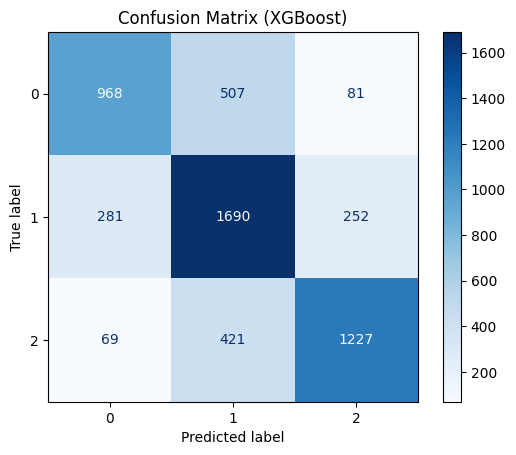

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (XGBoost)")
plt.show()


In [36]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_test_pred_xgb)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.62      0.67      1556
           1       0.65      0.76      0.70      2223
           2       0.79      0.71      0.75      1717

    accuracy                           0.71      5496
   macro avg       0.72      0.70      0.71      5496
weighted avg       0.71      0.71      0.71      5496



Найкращий результат на тесті — XGBoost:
Дає найвищу Test Accuracy (70.7%) та F1 (70.7%)

Модель часто плутає клас 0 і клас 1.

Можливо, ці класи мають схожий контекст слів.

В класі 2 також є помилки з класом 1 → 421 випадок.


### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [37]:
# XGBoost модель
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.5,
    max_depth=7,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    verbose=-1
)
xgb_model.fit(X_train_bow, y_train)

# Отримання важливостей ознак із моделі XGBoost
feature_importances = xgb_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Створимо DataFrame для зручності
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances
})

# Відсортуємо та візьмемо топ-20 найбільш впливових слів
top_features = importance_df.sort_values(by="importance", ascending=False).head(20)

print("Топ-20 найбільш впливових слів (XGBoost):")
print(top_features)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:00:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Топ-20 найбільш впливових слів (XGBoost):
      feature  importance
9032    thank    0.009287
3732    happi    0.008641
3793     hate    0.006208
8162      sad    0.005334
188      amaz    0.005091
7120     nice    0.004746
393    awesom    0.004578
6236     love    0.004520
8825     suck    0.004415
4407     hurt    0.004304
9375      ugh    0.004074
715      bore    0.003705
3410    great    0.003701
2118     fail    0.003701
8407     sick    0.003688
2056    excit    0.003634
1965    enjoy    0.003583
8811   stupid    0.003430
3845  headach    0.003373
1456     cute    0.003361


Виглядає на те, що модель правильно визначила емоційно забарвлені токени: thank, hate, love, happi, amaz, excit. Ці слова є емоційно забарвленими.

In [38]:
#Топ-10 найбільш впливових слів (LogisticRegression)
for i, label in enumerate(lr.classes_):
    print(f"\n🔹 Топ-10 важливих слів для класу {label}")
    feature_importance = pd.Series(
        lr.coef_[i],
        index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)
    print("🔼 Позитивні:", feature_importance.head(10).to_dict())
    print("🔽 Негативні:", feature_importance.tail(10).to_dict())


🔹 Топ-10 важливих слів для класу 0
🔼 Позитивні: {'sad': 2.6571146384646362, 'suck': 2.480433519422016, 'bore': 2.3579205428145773, 'sorri': 2.3333728027808625, 'hate': 2.242904482076814, 'fail': 2.132619921856917, 'miss': 2.093063530117982, 'stupid': 2.0798506903517757, 'exhaust': 2.0522928878271074, 'headach': 1.986394045078609}
🔽 Негативні: {'great': -1.5395060215745675, 'amaz': -1.5825596434642126, 'enjoy': -1.616860495834412, 'welcom': -1.7202939014986134, 'cute': -1.8251676955804634, 'thank': -1.9310999874873085, 'beauti': -2.0048556885472446, 'love': -2.0955120463653443, 'glad': -2.3063015826828264, 'awesom': -2.332243209761874}

🔹 Топ-10 важливих слів для класу 1
🔼 Позитивні: {'indoor': 1.5520020273165718, 'otherwis': 1.264070919486286, 'oooo': 1.21170391575661, 'raimi': 1.1893579814230235, 'parvo': 1.13328703951269, 'himh': 1.1160501256876603, 'nigga': 1.0998761059199522, 'nanci': 1.0899116444245764, 'hummmmm': 1.0757514855043728, 'twhirl': 1.0694235472917641}
🔽 Негативні: {'m

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import re
import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



df = pd.read_csv("train.csv")

# Функція очищення тексту
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Завантаження стоп-слів і стемінг
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = list(stopwords.words("english"))
stemmer = SnowballStemmer("english")

# Токенізація зі стемінгом
def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return tokens

# Очищення тексту
df['text_clean'] = df['text'].apply(clean_text)

# Кодування цільової змінної
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

# Розділення на train/test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['text_clean'], y, test_size=0.2, stratify=y, random_state=42
)


# Векторизація TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    stop_words=stop_words,
    lowercase=True,
    max_features=10000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [17]:
# Logistic Regression
lr_tfidf = LogisticRegression(solver='sag', max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_train_pred_lr_tfidf = lr_tfidf.predict(X_train_tfidf)
y_test_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

In [18]:
# XGBoost
xgb_tfidf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.5,
    max_depth=7,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_tfidf.fit(X_train_tfidf, y_train)
y_train_pred_xgb_tfidf = xgb_tfidf.predict(X_train_tfidf)
y_test_pred_xgb_tfidf = xgb_tfidf.predict(X_test_tfidf)

# Оцінка
results = {
    "LogisticRegression TF-IDF": {
        "Train": {
            "Accuracy": accuracy_score(y_train, y_train_pred_lr_tfidf),
            "F1": f1_score(y_train, y_train_pred_lr_tfidf, average='weighted')
        },
        "Test": {
            "Accuracy": accuracy_score(y_test, y_test_pred_lr_tfidf),
            "F1": f1_score(y_test, y_test_pred_lr_tfidf, average='weighted')
        }
    },
    "XGBoost TF-IDF": {
        "Train": {
            "Accuracy": accuracy_score(y_train, y_train_pred_xgb_tfidf),
            "F1": f1_score(y_train, y_train_pred_xgb_tfidf, average='weighted')
        },
        "Test": {
            "Accuracy": accuracy_score(y_test, y_test_pred_xgb_tfidf),
            "F1": f1_score(y_test, y_test_pred_xgb_tfidf, average='weighted')
        }
    }
}

results

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:58:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'LogisticRegression TF-IDF': {'Train': {'Accuracy': 0.7915302037845706,
   'F1': 0.7916054734535357},
  'Test': {'Accuracy': 0.6960160087320356, 'F1': 0.696320275053029}},
 'XGBoost TF-IDF': {'Train': {'Accuracy': 0.8918759097525473,
   'F1': 0.8920134059401765},
  'Test': {'Accuracy': 0.6971075131890122, 'F1': 0.6971520858447363}}}

In [7]:
# Дані з попередніх експериментів BoW
bow_results = pd.DataFrame({
    ('LogisticRegression BoW', 'Train'): {'Accuracy': 0.8491, 'F1': 0.8491},
    ('LogisticRegression BoW', 'Test'): {'Accuracy': 0.6874, 'F1': 0.6879},
    ('XGBoost BoW', 'Train'): {'Accuracy': 0.8383, 'F1': 0.8382},
    ('XGBoost BoW', 'Test'): {'Accuracy': 0.7069, 'F1': 0.7071},
}).T

# Актуальні результати TF-IDF
tfidf_results = pd.DataFrame({
    ('LogisticRegression TF-IDF', 'Train'): {'Accuracy': 0.7915, 'F1': 0.7916},
    ('LogisticRegression TF-IDF', 'Test'): {'Accuracy': 0.6960, 'F1': 0.6963},
    ('XGBoost TF-IDF', 'Train'): {'Accuracy': 0.8919, 'F1': 0.8920},
    ('XGBoost TF-IDF', 'Test'): {'Accuracy': 0.6971, 'F1': 0.6972},
}).T

# Об'єднання результатів
comparison_df = pd.concat([bow_results, tfidf_results])
comparison_df.index.names = ['Model', 'Dataset']
comparison_df

Accuracy      F1
Model                     Dataset                  
LogisticRegression BoW    Train      0.8491  0.8491
                          Test       0.6874  0.6879
XGBoost BoW               Train      0.8383  0.8382
                          Test       0.7069  0.7071
LogisticRegression TF-IDF Train      0.7915  0.7916
                          Test       0.6960  0.6963
XGBoost TF-IDF            Train      0.8919  0.8920
                          Test       0.6971  0.6972

## Висновок

TF-IDF покращив результат LogisticRegression на тесті та знизив перенавчання.

XGBoost із TF-IDF показує ознаки перенавчання, тому BoW там працює стабільніше.

Logistic Regression + TF-IDF — оптимальний вибір на цьому етапі.

In [19]:
features = tfidf_vectorizer.get_feature_names_out()

# Ваги (коефіцієнти) моделі по кожному класу
coefs = lr_tfidf.coef_

# Зберемо важливі слова для кожного класу
top_tokens_per_class = {}
for i, class_label in enumerate(le.classes_):
    top_tokens = pd.Series(coefs[i], index=features).sort_values(ascending=False)
    top_tokens_per_class[class_label] = top_tokens.head(10)

top_tokens_df_tfidf = pd.DataFrame(top_tokens_per_class).T
top_tokens_df_tfidf

,airport,amaz,awesom,bore,differ,england,excit,fail,good,great,...,plz,relat,sad,sent,sorri,stupid,suck,thank,tho,tire
negative,NaN,NaN,NaN,4.037817,NaN,NaN,NaN,3.651141,NaN,NaN,...,NaN,NaN,5.395153,NaN,4.518504,3.241268,4.265562,NaN,NaN,3.423202
neutral,0.956322,NaN,NaN,NaN,1.043874,1.079224,NaN,NaN,NaN,NaN,...,1.027031,1.053912,NaN,0.994206,NaN,NaN,NaN,NaN,0.941791,NaN
positive,NaN,4.26635,4.975433,NaN,NaN,NaN,3.933644,NaN,4.529565,4.673119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.01299,NaN,NaN


TF-IDF виокремлює специфічні, рідкісні слова
У класі positive — слова: love, amaz, awesom, smile — сильні емоційні маркери, але не обовʼязково часті.

У класі negative — suck, stupid, ugh, headach — іноді зустрічаються рідко, але мають високий внесок у класифікацію.

TF-IDF дає високі ваги словам, які мало де зустрічаються, але дуже характерні для певного класу.

BoW (XGBoost) орієнтується на часті слова
Часто потрапляють слова, які багато разів зустрічались у тренувальному наборі: thank, happi, love, great, hate, sad, nice.

Більше загальних слів, що можуть бути у кількох класах.

Logistic Regression + TF-IDF — найкращий компроміс між якістю, стабільністю та інтерпретованістю.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [20]:
# Logistic Regression
lr_tfidf = LogisticRegression(solver='sag', max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_train_pred_lr_tfidf = lr_tfidf.predict(X_train_tfidf)
y_test_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)


# Аналіз помилок
errors_df = pd.DataFrame({
    'text': X_test_raw,
    'true': le.inverse_transform(y_test),
    'predicted': le.inverse_transform(y_test_pred_lr_tfidf)
})

# Лишаємо тільки хибні передбачення
errors_df = errors_df[errors_df['true'] != errors_df['predicted']]
errors_df.head(20)

,text,true,predicted
7069,babysitting kids who wont let me play wii with...,negative,neutral
17797,is watching the jonas brothers special on sky ...,neutral,positive
538,seems really quiet tonightam jealous of those ...,neutral,negative
25572,thers not many peole tweeting tonight well sup...,negative,neutral
6359,there is a baby cardinal fallen out of its nes...,neutral,negative
1027,omg jonas is my new fave show one guess as to...,positive,neutral
4605,morningtired should i excercise or jus relax n...,neutral,positive
8953,i have to admit im a bit bummed out that i was...,negative,neutral
8431,good morninghoping to throw back some coffee l...,neutral,positive
20089,ohhh yea it is from the same film and this o...,positive,neutral


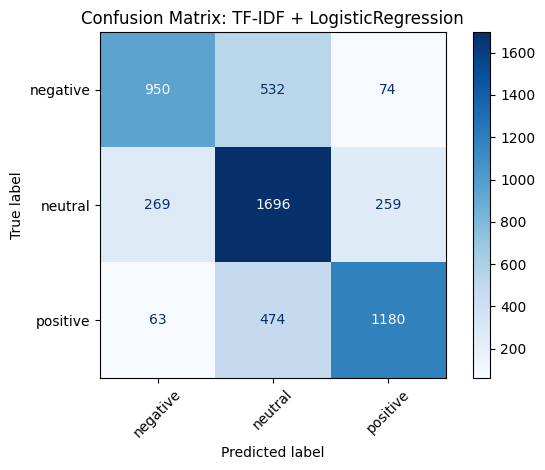

In [21]:
cm = confusion_matrix(y_test, y_test_pred_lr_tfidf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: TF-IDF + LogisticRegression")
plt.grid(False)
plt.tight_layout()
plt.show()

##Висновок

Найкраще класифікується клас neutral — модель найменше плутається.

Найбільше плутаються negative та positive з neutral, тобто: модель має схильність до нейтрального класу.

Можливо, тексти у класі neutral мають слова, які часто з’являються і в інших класах, але без яскраво вираженої тональності.

Помилки між negative  positive — найменші — тобто модель впевнено розділяє ці крайні класи, але менш точно — від нейтрального.

Що можна покращити:

Можливо, зменшити розмір словника (max_features), щоб прибрати менш значущі слова.

Або спробувати усунути класовий дисбаланс (якщо він є).

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model